In [1]:
# -------------------------

# This notebook includes the analysis tools used in the final presentation

# -------------------------
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.simplefilter(action='ignore')
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import zipfile
import geopandas as gpd
from shapely.geometry import Point, LineString
from scipy import stats
import datetime
import matplotlib.dates as mdates
import plotly.graph_objects as go
from matplotlib.ticker import MaxNLocator
import re
from dateutil.relativedelta import relativedelta
import matplotlib.ticker as mticker


In [2]:
season_queries = {
    "2023-1": "service_date >= '2022-12-18' & service_date <= '2023-03-11'",
    "2023-2": "service_date >= '2023-03-12' & service_date <= '2023-07-02'",
    "2023-3": "service_date > '2023-07-02' & service_date <= '2023-08-26'",
    "2023-4"  : "service_date >= '2023-08-27' & service_date <= '2023-12-16'",
    "2024-1": "service_date >= '2023-12-17' & service_date <= '2024-04-06'",
    "2024-2": "service_date >= '2024-04-07' & service_date <= '2024-06-15'",
    "2024-3": "service_date >= '2024-06-16' & service_date <= '2024-08-24'",
    "2024-4"  : "service_date > '2024-08-24' & service_date <= '2024-12-14'",
    "2025-1": "service_date > '2024-12-14' & service_date <= '2025-04-06'",
    "2025-2": "service_date > '2025-04-06' & service_date <= '2025-06-14'",
}

In [3]:
# -------------------------

# Read pre-calculated dataframes from data_process.ipynb
# df_all: cleaned AVL data
# sd_all: trip-level runtimes
# combined: HASTUS schedules between 2023-1 to 2025-3

# -------------------------


df_all = pd.read_csv('df_all.csv')

df_all["service_date"]     = pd.to_datetime(df_all["service_date"],     format="%Y-%m-%d",              errors="coerce")
df_all["scheduled_boston"] = pd.to_datetime(df_all["scheduled_boston"], format="%Y-%m-%d %H:%M:%S",     errors="coerce")
df_all["actual_boston"]    = pd.to_datetime(df_all["actual_boston"],    format="%Y-%m-%d %H:%M:%S",     errors="coerce")

all_available_routes = df_all.drop_duplicates('route_id')
all_available_routes = all_available_routes[all_available_routes['route_id'].astype(str).str.strip().str.fullmatch(r'\d+')]



sd_all = pd.read_csv('sd_all.csv')
sd_all['service_date']    = pd.to_datetime(sd_all['service_date'])


combined = pd.read_csv('combined.csv')


In [4]:
df_all = df_all.rename(columns={'timepointid':'time_point_id'})


In [5]:
# -------------------------

# One digit routes (such as Route 1) are recorded as '01' in database, so we are assigning a 
# route key to avoid integer/string mismatch

# -------------------------

def _route_key(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()

    m = re.fullmatch(r'0*(\d+)([A-Za-z]*)', s)
    if m:
        num = str(int(m.group(1)))           # drop leading zeros
        suf = m.group(2).upper()             # normalize suffix casing
        return num + suf

    return s.upper()
    
if 'route_key' not in sd_all.columns:
    sd_all = sd_all.copy()
    sd_all['route_key'] = sd_all['route_id'].map(_route_key)

if 'route_key' not in combined.columns:
    combined = combined.copy()
    combined['route_key'] = combined['Route'].map(_route_key)


In [6]:
# -------------------------

# For practicality we are dropping the route names that include a letter (SL1, 34E..)

# -------------------------

combined = combined[combined['Route'].astype(str).str.strip().str.fullmatch(r'\d+')]

# There are some routes that have entries in the schedule but not on in the AVL data after cleaning (714,1013)

combined_28 = combined[combined['Route'].astype(int).isin(sd_all['route_id'].astype(int).unique())]

combined_28['time_dir'] = combined_28['Start'].astype(str)+combined_28['Direction'].astype(str)+ \
         combined_28['rat_id'].astype(str)+combined_28['DOW'].astype(str)+combined_28['type_d'].astype(str)+combined_28['Route'].astype(str)

# There are some routes that have multiple busses running the same schedule (variant?)

cnts = combined_28.value_counts('time_dir').reset_index()
cnts = cnts[cnts['count']==1]
combined_28 = combined_28[combined_28['time_dir'].isin(cnts['time_dir'])]

In [7]:
df_all['delay_min'] = (df_all['actual_boston'] - df_all['scheduled_boston'])\
                        .dt.total_seconds() / 60

starts = df_all[(df_all['point_type']=='Startpoint')]
id_keeps = starts[(starts['delay_min']<=15)&(starts['delay_min']>-10)]['half_trip_id']

df_all_cleaned = df_all[df_all['half_trip_id'].isin(id_keeps)]

sd_all_cleaned = sd_all[sd_all['half_trip_id'].isin(id_keeps)]


In [8]:
print(len(df_all_cleaned)/len(df_all))
print(len(sd_all_cleaned)/len(sd_all))

0.9589006370383601
0.9605531021196033


In [9]:
# -------------------------

# Read the latest MBTA GTFS for bus route shapefiles

# -------------------------

feed = "MBTA_GTFS.zip"
with zipfile.ZipFile(feed) as z:
    routes      = pd.read_csv(z.open("routes.txt"))
    trips       = pd.read_csv(z.open("trips.txt"))
    stop_times  = pd.read_csv(z.open("stop_times.txt"))
    stops       = pd.read_csv(z.open("stops.txt"))
    shapes      = pd.read_csv(z.open("shapes.txt"))

shapes_sorted = (shapes
                 .sort_values(["shape_id", "shape_pt_sequence"])
                 .loc[:, ["shape_id", "shape_pt_lon", "shape_pt_lat"]])

geometry_by_shape = (shapes_sorted
                     .groupby("shape_id")        
                     .apply(lambda df: LineString(zip(df.shape_pt_lon,
                                                     df.shape_pt_lat)))
)

shape_gdf = gpd.GeoDataFrame(
    geometry_by_shape.rename("geometry"),
    crs="EPSG:4326"      
).reset_index()            
shape_route_map = (trips[["route_id", "shape_id"]]
                   .drop_duplicates())

# choose the most-frequent shape per route
canonical = (trips.value_counts(["route_id", "shape_id"])
                    .rename("n_trips")
                    .reset_index()
                    .sort_values(["route_id", "n_trips"], ascending=[True, False])
                    .drop_duplicates("route_id"))[["route_id", "shape_id"]]

shape_route_map = canonical

route_gdf = (shape_route_map
             .merge(shape_gdf, on="shape_id", how="left")
             .merge(routes[["route_id", "route_long_name",
                            "route_short_name", "route_type"]],
                    on="route_id", how="left"))

route_gdf = gpd.GeoDataFrame(route_gdf, geometry="geometry", crs="EPSG:4326")


In [10]:

sd_all_mrg = sd_all.merge(combined_28[['time_dir','Act_Layover','Variant']])


sd_all_mrg = (
    sd_all_mrg[pd.to_numeric(sd_all_mrg['Act_Layover'], errors='coerce').notna()]
      .assign(Act_Layover=lambda df: df['Act_Layover'].astype(float))
)

sd_all_mrg['schdLO']  = sd_all_mrg['scheduled_run'] + sd_all_mrg['Act_Layover']


agg = sd_all_mrg.groupby('time_dir').agg(
    actual_run_q90=('actual_run', lambda x: x.quantile(0.90)),
    mean_schd     =('scheduled_run',    'mean'),
    mean_lo     =('Act_Layover',    'mean')).reset_index()

df_out = sd_all_mrg.merge(
agg[['time_dir','actual_run_q90','mean_schd','mean_lo']],
on='time_dir',
how='left'
)
df_out = df_out.drop_duplicates('time_dir')[['actual_run_q90','mean_schd','mean_lo','time_dir','season','holiday','direction_id','schedule_type','hour_Startpoint',
                                             'scheduledhm_Startpoint','DOW','route_id','schdLO','Variant']]


0.06850022956841138
-0.21422685185185195


(0.0, 100.0)

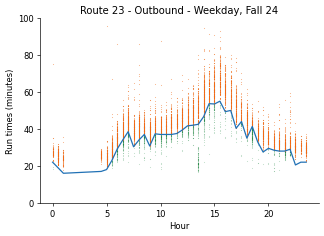

In [11]:
plt1 = df_out[(df_out['season']=='2024-4')&(df_out['DOW']=='Weekday')&(df_out['route_id']==23)&(df_out['direction_id']=='Outbound')&(df_out['schedule_type']=='N')]
plt1 = plt1[['schdLO','actual_run_q90','hour_Startpoint']].groupby('hour_Startpoint').mean()

defs = plt1[plt1['actual_run_q90']>plt1['schdLO']]
print(np.sum(defs['actual_run_q90'] - defs['schdLO'])/np.sum(plt1['schdLO']))

surps = plt1[plt1['actual_run_q90']<plt1['schdLO']]
print(np.sum(surps['actual_run_q90'] - surps['schdLO'])/60)

fig, ax = plt.subplots(figsize=(6,4), dpi=60)

sd_fall24 = sd_all[(sd_all['season']=='2024-4')&(sd_all['DOW']=='Weekday')&(sd_all['route_id']==23)&(sd_all['direction_id']=='Outbound')]
sd_fall24 = sd_fall24.merge(plt1.reset_index(),on='hour_Startpoint')
sd_fall24_ = sd_fall24[sd_fall24['actual_run']<sd_fall24['schdLO']-9]
sd_fall24_2 = sd_fall24[sd_fall24['actual_run']>sd_fall24['schdLO']-9]

plt.scatter(sd_fall24_['hour_Startpoint'],sd_fall24_['actual_run'],color='#238b45',s=0.08,label='Individual run times',alpha=0.4)
plt.scatter(sd_fall24_2['hour_Startpoint'],sd_fall24_2['actual_run'], facecolors='#f16913', s=0.08, marker='o',label='Individual run times',alpha=0.7)


#plt.plot(plt1['actual_run_q90'],color='#2171b5',label='90th percentile line',linestyle='--')
plt.plot(plt1['schdLO']-9,color='#2171b5',label='Scheduled + Lay Over time')

#ax.axvspan(15.25, 15.75,        color='red',       alpha=0.15,         linewidth=0)

sns.despine()
plt.xlabel('Hour')
plt.ylabel('Run times (minutes)')
plt.title('Route 23 - Outbound - Weekday, Fall 24')
#plt.legend()
plt.ylim(0,100)


In [12]:
def segment_diffs(df, season, time_col):
    """
    Compute per-trip segment runtimes
    """
    out = []
    # ensure consistent types
    df = df.copy()
    for k in sorted(df['time_point_order'].unique()):
        end = (df[df['time_point_order'] == k + 1]
               [['half_trip_id', time_col, 'time_point_id', 'route_id', 'direction_id']]
               .rename(columns={time_col: 't_end', 'time_point_id': 'time_point_order_end'}))
        start = (df[df['time_point_order'] == k]
                 [['half_trip_id', time_col, 'hour', 'time_point_id', 'route_id', 'direction_id','stop_id']]
                 .rename(columns={time_col: 't_start'}))
        merged = start.merge(end, on=['half_trip_id', 'route_id', 'direction_id'], how='inner')
        merged['k'] = k
        merged['time_diff'] = (merged['t_end'] - merged['t_start']).dt.total_seconds() / 60
        out.append(merged[['half_trip_id','route_id','direction_id','k','hour',
                           'time_diff','time_point_id','time_point_order_end','stop_id']])
    seg = pd.concat(out, ignore_index=True)
    seg['season'] = season
    seg['kind']   = 'actual' if 'actual' in time_col else 'scheduled'
    seg = seg[seg['time_diff'] > 0]
    return seg

season = '2025-1'
DOW = 'Weekday'
direction = 'Outbound'
routes = ['23','28']

base = df_all.query(season_queries[season]).copy()

base = base[(base['DOW'] == DOW) &
            (base['direction_id'] == direction) &
            (base['route_id'].isin(routes))].copy()

# Nubn and dudly tags are used for the same stop
base['time_point_id'] = base['time_point_id'].astype(str).str.replace(
    r'^\s*nubn\s*$', 'dudly', case=False, regex=True
)
# compute per-trip segment runtimes
actual = segment_diffs(base, season, 'actual_boston')
sched  = segment_diffs(base, season, 'scheduled_boston')

# keep "typical" trips per route (median segment count by half_trip_id within each route)
cnts = (actual.groupby(['route_id','half_trip_id'])
              .size()
              .reset_index(name='count'))
med_by_route = cnts.groupby('route_id')['count'].median().to_dict()
keep = cnts[cnts.apply(lambda r: r['count'] == med_by_route.get(r['route_id'], r['count']), axis=1)]
keep_key = set(zip(keep['route_id'], keep['half_trip_id']))

actual = actual[actual.apply(lambda r: (r['route_id'], r['half_trip_id']) in keep_key, axis=1)]
sched  = sched [sched .apply(lambda r: (r['route_id'], r['half_trip_id']) in keep_key, axis=1)]

# match actual vs scheduled (per trip/segment/route)
mapit = actual.merge(
    sched[['half_trip_id','route_id','direction_id','k','hour','time_diff']],
    on=['half_trip_id','route_id','direction_id','k','hour'],
    how='inner',
    suffixes=('_x','_y')  # -> time_diff_x (actual) & time_diff_y (scheduled)
)
mapit['season'] = season
rugg_mapit = mapit[mapit['time_point_id']=='rugg']

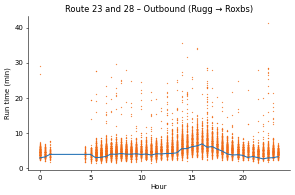

In [13]:

# --- 1. flag points ≥ median + 5 -------------------------------------------
hour_median = (
    rugg_mapit
      .groupby('hour')['time_diff_x']          # median run-time per departure hour
      .median()
)

mask = rugg_mapit['time_diff_x'] > rugg_mapit['hour'].map(hour_median) + 8

# --- 2. plot -----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4), dpi=50)

# scheduled curve
plt.plot(
    rugg_mapit[['hour', 'time_diff_y']].groupby('hour').mean(),
    color='#2171b5', label='Scheduled + Lay-over'
)
plt.scatter(rugg_mapit['hour'], rugg_mapit['time_diff_x'],facecolors='#f16913', s=0.8, marker='o', alpha=0.7,label='Individual run times')

# all individual runs (filled orange dots)
#plt.scatter(rugg_mapit.loc[~mask, 'hour'], rugg_mapit.loc[~mask, 'time_diff_x'],facecolors='#f16913', s=0.8, marker='o', alpha=0.7,label='Individual run times')

# overlay “far-above-median” runs (hollow black rings)
#plt.scatter(rugg_mapit.loc[mask, 'hour'], rugg_mapit.loc[mask, 'time_diff_x'],facecolors='none', edgecolors='black',linewidths=0.5, s=16, marker='o',label='> median + 5 min', zorder=3)

sns.despine()
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
plt.xlabel('Hour')
plt.ylabel('Run time (min)')
plt.title('Route 23 and 28 – Outbound (Rugg → Roxbs)')
#plt.legend()
plt.tight_layout()
plt.savefig('pm')

In [14]:
def process_apc(apc_data):

    new_cols = ["TRIP_DATE","BUS","ROUTE","VARIATION",'DAY_OF_WK',"BLOCK","DIRECTION","TRIP","STOP_ID","STOP_SEQ_ID","STOP_NAME",
    "ACT_STOP_TIME","ACT_DEP_TIME","ACT_MOVE_TIME","PSGR_ON","PSGR_OFF","PSGR_LOAD","LATITUDE","LONGITUDE","SCH_TIME",
    "DEVIATION_MINS","SCH_RUN_MINS","ACT_RUN_MINS","DOOR_CYCLES","GPS_ERROR_FT"]

    apc_data.columns = new_cols
    
    apc_data['schd_Stop']= apc_data['SCH_TIME'].astype(str) +apc_data['STOP_ID'].astype(str) 
    
    apc_data['TRIP_DATE']    = pd.to_datetime(apc_data['TRIP_DATE'])
    apc_data['SCH_TIME']    = pd.to_datetime(apc_data['SCH_TIME'])
    apc_data['ACT_STOP_TIME']    = pd.to_datetime(apc_data['ACT_STOP_TIME'])
    apc_data['ACT_DEP_TIME']    = pd.to_datetime(apc_data['ACT_DEP_TIME'])
    apc_data['ACT_MOVE_TIME']    = pd.to_datetime(apc_data['ACT_MOVE_TIME'])
    
    apc_data = apc_data[apc_data['DEVIATION_MINS']!=99]
    apc_data = apc_data[apc_data['SCH_RUN_MINS']!=99.9]
    apc_data = apc_data[apc_data['ACT_RUN_MINS']!=99.9]
    
    apc_data['id']=apc_data['TRIP_DATE'].astype(str)+apc_data['BUS'].astype(str)+apc_data['BLOCK'].astype(str)+apc_data['TRIP'].astype(str)
    
    apc_data['hour'] =  (
        apc_data['SCH_TIME'].dt.hour
      + (apc_data['SCH_TIME'].dt.minute // 30) * 0.5)

    # In a stop recorded multiple departure timestamps
    
    counts = pd.DataFrame(apc_data.value_counts('schd_Stop'))
    counts = counts[counts['count']==2]
    bad_ids2 = list(counts.index)
    apc_data = apc_data[~apc_data['schd_Stop'].isin(bad_ids2)]

    return apc_data



In [15]:
apc_data28 = pd.read_csv('Fall 24 Winter 25 Route 28 Ridecheck.csv')
apc_data28 = process_apc(apc_data28)

apc_data23 = pd.read_csv('Fall 24 Winter 25 Route 23 Ridecheck.csv')
apc_data23 = process_apc(apc_data23)

apc_data22 = pd.read_csv('Fall 24 Winter 25 Route 22 Ridecheck.csv')
apc_data22 = process_apc(apc_data22)


In [16]:
apc_data = pd.concat([apc_data23,apc_data28])

apc_data_wo=apc_data[(apc_data['DAY_OF_WK']==1)&(apc_data['DIRECTION']==2)]

In [17]:
AVL = pd.read_excel('Summary AVL_data (2).xlsx')
AVL = AVL[['Route','Measure Values']]
AVL = AVL.rename(columns={'Measure Values':'AVL'})

APC = pd.read_excel('Summary APC_data (2).xlsx')
APC = APC[['Route','Measure Values']]
APC = APC.rename(columns={'Measure Values':'APC'})


In [18]:
AVL = AVL.merge(APC,on='Route').dropna()
AVL['diff'] = AVL['AVL']-AVL['APC']

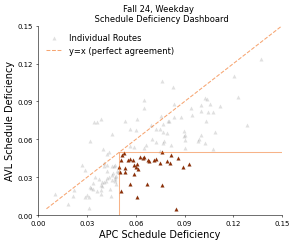

In [19]:

df = AVL

fig, ax = plt.subplots(figsize=(6, 5), dpi=50)
plt.scatter(df["APC"], df["AVL"], s=32,color='.4',edgecolor='.8',linewidth=0.1,alpha=0.2,marker='^',label='Individual Routes')

zone_ = AVL[(AVL['AVL']<0.05)&(AVL['APC']>0.05)]
plt.scatter(zone_['APC'],zone_['AVL'], s=32,color='#8c2d04',edgecolor='.8',linewidth=0.1,marker='^')

plt.plot([df[["AVL","APC"]].min().min(), df[["AVL","APC"]].max().max()],
         [df[["AVL","APC"]].min().min(), df[["AVL","APC"]].max().max()],
         'r--', label="y=x (perfect agreement)",color='#f16913',alpha=0.6)

ax.set_xlabel('APC Schedule Deficiency',fontsize=14)
ax.set_ylabel('AVL Schedule Deficiency',fontsize=14)

ax.vlines(x=0.05, ymin=0.0, ymax=0.05, color='#f16913',alpha=0.5)
ax.hlines(y=0.05, xmin=0.05, xmax=0.15, color='#f16913',alpha=0.5)

plt.title('Fall 24, Weekday \n Schedule Deficiency Dashboard')

ax.legend(frameon=False, fontsize=12)
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
ax.xaxis.set_major_locator(mticker.MaxNLocator(5))
plt.xlim(0,0.15)
plt.ylim(0,0.15)
sns.despine()
plt.tight_layout()
plt.savefig('pm')


In [20]:
zone_1 = AVL[(AVL['AVL']>0.05)&(AVL['APC']<0.05)]
zone_1 = zone_1.sort_values('diff')


zone_2 = AVL[(AVL['AVL']<0.05)&(AVL['APC']>0.05)]
zone_2 = zone_2.sort_values('diff').iloc[:10]

In [21]:
import contextily as cx

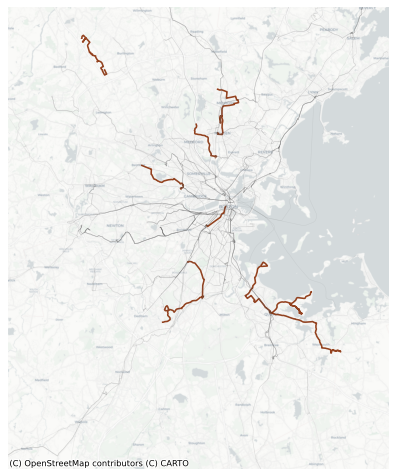

In [23]:
hgh_routes = list(zone_2.Route.astype(str))
hgh = route_gdf[route_gdf['route_id'].isin(hgh_routes)]
fig, ax = plt.subplots(figsize=(8, 8), dpi=75)

hgh.plot(ax=ax,color='#8c2d04',alpha=0.9)

route_gdf.plot(ax=ax,color='.4',alpha=0.1,linewidth=0.5)


ax.set_axis_off()
plt.xlim(-71.35,-70.85)
plt.ylim(42.1,42.55)
cx.add_basemap(ax, crs=4326,source=cx.providers.CartoDB.Positron, zoom=12)
plt.savefig('pm')

In [24]:
all_rt = sd_all_mrg[sd_all_mrg['route_key'].isin(AVL['Route'].astype(str))].groupby('route_key').mean('actual_run')

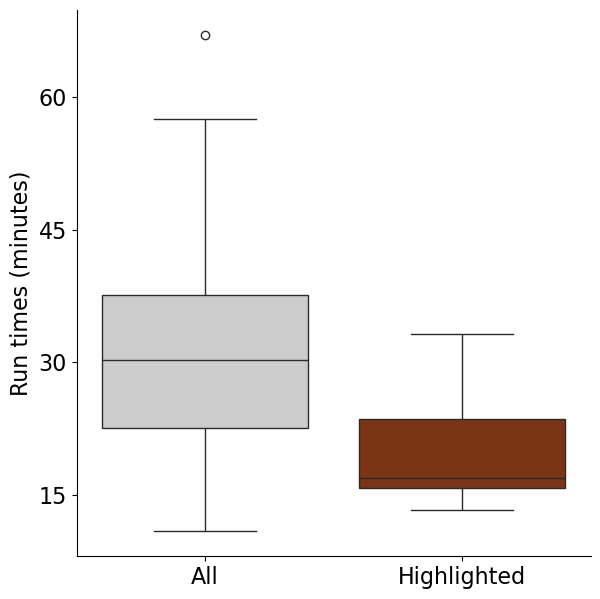

In [25]:
hgh_rt  = sd_all_mrg[sd_all_mrg['route_key'].isin(hgh_routes)].groupby('route_key').mean('actual_run')

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

palette = {
    "All": "#cccccc40",  
    "Highlighted": "#8c2d04"    
}

df = pd.concat([
    pd.DataFrame({'actual_run': all_rt['actual_run'], 'group': 'All'}),
    pd.DataFrame({'actual_run': hgh_rt['actual_run'], 'group': 'Highlighted'})
])

sns.boxplot(x='group', y='actual_run', data=df, palette=palette)
plt.xlabel("")
sns.despine()

plt.ylabel('Run times (minutes)',fontsize=16)
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
plt.tight_layout()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('pm')


In [26]:
nub1 = apc_data_wo[(apc_data_wo['STOP_NAME']=='MALCOLM X BLVD @ KING ST')&(apc_data_wo['TRIP_DATE']>'2024-12-14')]

APC_ = nub1.groupby('hour').mean('ACT_RUN_MINS')['ACT_RUN_MINS']
AVL_ = rugg_mapit.groupby('hour').mean('time_diff_x')['time_diff_x']

diff = AVL_.reset_index().merge(APC_.reset_index())
diff = diff[diff['hour']>5]
diff['diff'] = diff['time_diff_x'] - diff['ACT_RUN_MINS']

In [27]:
scipy.stats.pearsonr(APC_, AVL_)

PearsonRResult(statistic=0.6432110550153405, pvalue=4.348167105600588e-06)

In [129]:
rt_28_cleaned = pd.read_csv('rt_28_cleaned.csv')

In [130]:
rugg_mapit['key'] = (
    rugg_mapit['half_trip_id'].astype(str) 
    + rugg_mapit['stop_id'].astype(str) 
    + rugg_mapit['direction_id'].astype(str)
)
rugg_mapit2= rugg_mapit[rugg_mapit['key'].isin(rt_28_cleaned['key'])]

In [224]:
rugg_mapit3 =  rugg_mapit[rugg_mapit['half_trip_id'].isin(id_keeps)]

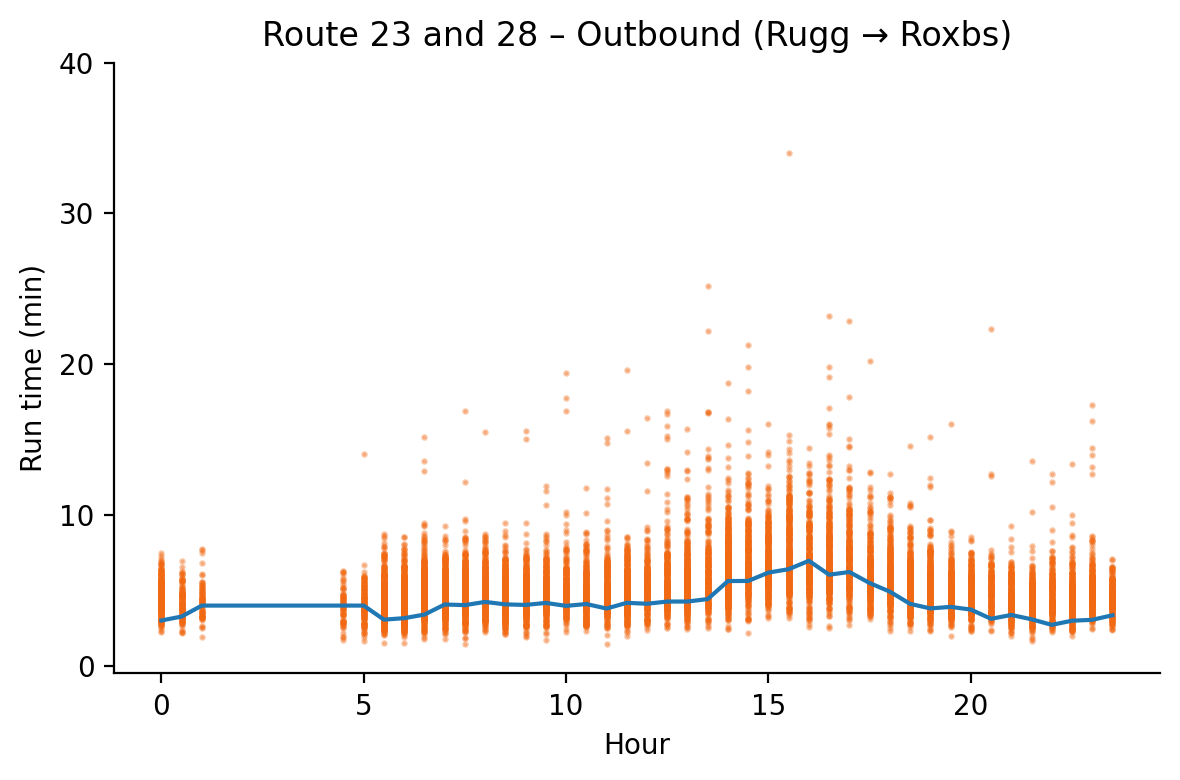

In [225]:

x2 = nub1['hour']
y2 = nub1['ACT_RUN_MINS']

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
#plt.scatter(rugg_mapit['hour'], rugg_mapit['time_diff_x'],facecolors='#f16913', s=1.8, alpha=0.35,label='Individual run times (AVL)')
plt.scatter(rugg_mapit3['hour'], rugg_mapit3['time_diff_x'],facecolors='#f16913', s=1.8, alpha=0.35,label='Individual run times (AVL)')
#plt.scatter(rugg_mapit2['hour'], rugg_mapit2['time_diff_x'],facecolors='#f16913', s=1.8, alpha=0.35,label='Individual run times (AVL)')

plt.plot(rugg_mapit.groupby('hour').mean('time_diff_y')['time_diff_y'])

# Scatter with empty circles (transparent face, colored edge)
#ax.scatter(x2, y2, facecolors='none', edgecolors='#4575b4', s=1.8, alpha=0.35,label='APC')

#ax.set_xlim(5, 24)
plt.ylim(-0.5,40)
plt.xlabel('Hour')
plt.ylabel('Run time (min)')
plt.title('Route 23 and 28 – Outbound (Rugg → Roxbs)')

#ax.set_title(f'Trip {ka} Comparison at Stop {target_seq_out[ka]}')
#ax.legend(frameon=False, fontsize=10)
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))

sns.despine()
plt.tight_layout()
plt.savefig('pm')


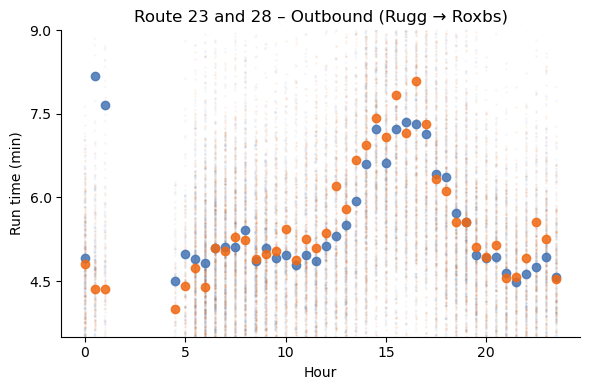

In [57]:

x2 = nub1['hour']
y2 = nub1['ACT_RUN_MINS']

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
plt.scatter(rugg_mapit['hour'], rugg_mapit['time_diff_x'],facecolors='#f16913', s=0.8, alpha=0.1,label='Individual run times (AVL)')

ax.scatter(x2, y2, facecolors='none', edgecolors='#4575b4', s=0.8, alpha=0.05,label='APC')

plt.scatter(APC_.reset_index()['hour'],APC_.reset_index()['ACT_RUN_MINS'], facecolors='#4575b4',label='APC',alpha=0.85)
plt.scatter(AVL_.reset_index()['hour'],AVL_.reset_index()['time_diff_x'],facecolors='#f16913',label='Individual run times (AVL)',alpha=0.85)

#ax.set_xlim(5, 24)
plt.ylim(3.5,9)
plt.xlabel('Hour')
plt.ylabel('Run time (min)')
plt.title('Route 23 and 28 – Outbound (Rugg → Roxbs)')

#ax.set_title(f'Trip {ka} Comparison at Stop {target_seq_out[ka]}')
#ax.legend(frameon=False, fontsize=10)
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))

sns.despine()
plt.tight_layout()
plt.savefig('pm')


In [217]:
mask = (
    (sd_all_mrg['season'] == '2024-4') &
    (sd_all_mrg['direction_id'] == 'Outbound') &
    (sd_all_mrg['DOW'] == 'Weekday')
)
core = sd_all_mrg.loc[mask,  
                      ['route_key', 'hour_Startpoint', 'scheduledhm_Startpoint',
                       'actual_run', 'schdLO']]

core2 = sd_all_mrg[sd_all_mrg['half_trip_id'].isin(id_keeps)].loc[mask,  
                      ['route_key', 'hour_Startpoint', 'scheduledhm_Startpoint',
                       'actual_run', 'schdLO']]


def deficiency_ratio(df: pd.DataFrame, bin_col: str) -> pd.Series:

    g = (df
         .groupby(['route_key', bin_col], as_index=False)
         .agg(actual_run=('actual_run', lambda x: x.quantile(0.9)), 
              schdLO     =('schdLO',     'mean')))

    g['pos_diff'] = (g['actual_run'] - g['schdLO']).clip(lower=0)

    sums = g.groupby('route_key').agg(
        num=('pos_diff', 'sum'),
        den=('schdLO',   'sum')
    )
    return sums['num'] / sums['den']


defs_hr = deficiency_ratio(core, 'hour_Startpoint')      
defs_rt = deficiency_ratio(core, 'scheduledhm_Startpoint')  

defs_hr_clean = deficiency_ratio(core2, 'hour_Startpoint')      
defs_rt_clean = deficiency_ratio(core2, 'scheduledhm_Startpoint')  


out = (pd.concat({'def_hr': defs_hr, 'def_rt': defs_rt}, axis=1)
         .reset_index()
         .rename(columns={'route_key': 'route'}))

out_clean = (pd.concat({'def_hr': defs_hr_clean, 'def_rt': defs_rt_clean}, axis=1)
         .reset_index()
         .rename(columns={'route_key': 'route'}))

clean_not = out.merge(out_clean,on='route')

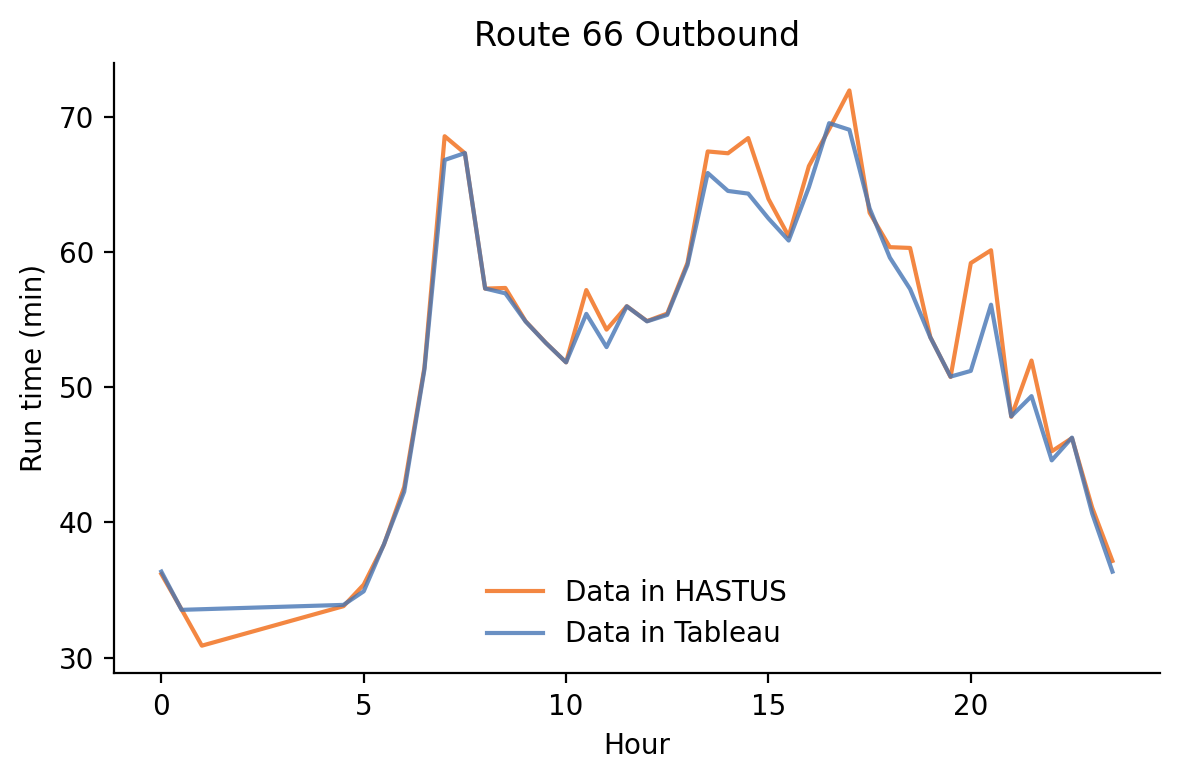

In [227]:
result = (
    core[core['route_key'] == '66']         
      .groupby('hour_Startpoint')          
      .agg(actual_run_90=('actual_run',  lambda s: s.quantile(0.90)),
           schdLO_mean =('schdLO',       'mean'))
      .reset_index()
)

result2 = (
    core2[core2['route_key'] == '66']         
      .groupby('hour_Startpoint')          
      .agg(actual_run_90=('actual_run',  lambda s: s.quantile(0.90)),
           schdLO_mean =('schdLO',       'mean'))
      .reset_index()
)

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

plt.plot(result['hour_Startpoint'],result['actual_run_90'],color='#f16913',label='Data in HASTUS',alpha=0.8)
plt.plot(result2['hour_Startpoint'],result2['actual_run_90'],color='#4575b4',label='Data in Tableau',alpha=0.8)


plt.xlabel('Hour')
plt.ylabel('Run time (min)')
plt.title('Route 66 Outbound')

#ax.set_title(f'Trip {ka} Comparison at Stop {target_seq_out[ka]}')
ax.legend(frameon=False, fontsize=10)
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))

sns.despine()
plt.tight_layout()
plt.savefig('pm')

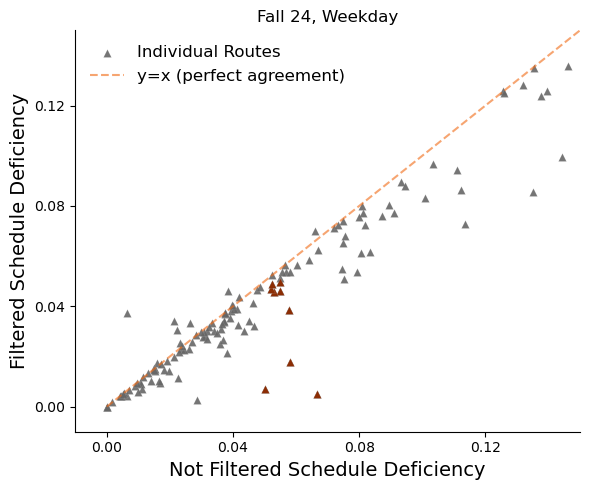

In [219]:

df = clean_not

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
plt.scatter(df["def_rt_x"], df["def_rt_y"], s=32,color='.4',edgecolor='.8',linewidth=0.1,alpha=0.9,marker='^',label='Individual Routes')

zone_ = df[(df['def_rt_x']>0.05)&(df['def_rt_y']<0.05)]
plt.scatter(zone_['def_rt_x'],zone_['def_rt_y'], s=32,color='#8c2d04',edgecolor='.8',linewidth=0.1,marker='^')

plt.plot([df[["def_rt_x","def_rt_y"]].min().min(), df[["def_rt_x","def_rt_y"]].max().max()],
         [df[["def_rt_x","def_rt_y"]].min().min(), df[["def_rt_x","def_rt_y"]].max().max()],
         'r--', label="y=x (perfect agreement)",color='#f16913',alpha=0.6)

ax.set_xlabel('Not Filtered Schedule Deficiency',fontsize=14)
ax.set_ylabel('Filtered Schedule Deficiency',fontsize=14)

#ax.vlines(x=0.05, ymin=0, ymax=0.05, color='#f16913',alpha=0.5)
#ax.hlines(y=0.05, xmin=0.05, xmax=0.15, color='#f16913',alpha=0.5)

plt.title('Fall 24, Weekday')

ax.legend(frameon=False, fontsize=12)
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
ax.xaxis.set_major_locator(mticker.MaxNLocator(5))
plt.xlim(-0.01,0.15)
plt.ylim(-0.01,0.15)
sns.despine()
plt.tight_layout()
plt.savefig('pm')

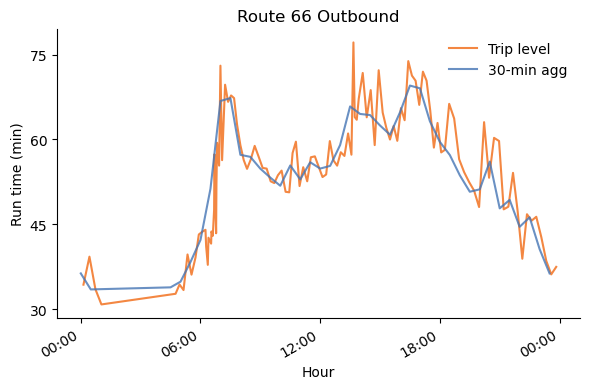

In [220]:
result = (
    core[core['route_key'] == '66']
        .groupby('scheduledhm_Startpoint')          # "HH:MM"
        .agg(actual_run_90=('actual_run', lambda s: s.quantile(0.90)),
             schdLO_mean  =('schdLO',      'mean'))
        .reset_index()
)

result2 = (
    core2[core2['route_key'] == '66']
        .groupby('hour_Startpoint')                 # 0.0, 0.5, 1.0, …
        .agg(actual_run_90=('actual_run', lambda s: s.quantile(0.90)),
             schdLO_mean  =('schdLO',      'mean'))
        .reset_index()
)

anchor_date = pd.Timestamp('1900-01-01')           

result['x_dt']  = pd.to_datetime(result['scheduledhm_Startpoint'], format='%H:%M')

result2['x_dt'] = anchor_date + pd.to_timedelta(result2['hour_Startpoint'], unit='h')

fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

ax.plot(result['x_dt'],  result['actual_run_90'],
        color='#f16913', label='Trip level', alpha=0.8)

ax.plot(result2['x_dt'], result2['actual_run_90'],
        color='#4575b4', label='30-min agg',    alpha=0.8)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.autofmt_xdate()               

ax.set_xlabel('Hour')
ax.set_ylabel('Run time (min)')
ax.set_title('Route 66 Outbound')
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
ax.xaxis.set_major_locator(mticker.MaxNLocator(5))

ax.legend(frameon=False, fontsize=10)
sns.despine()
plt.tight_layout()
plt.savefig('pm')


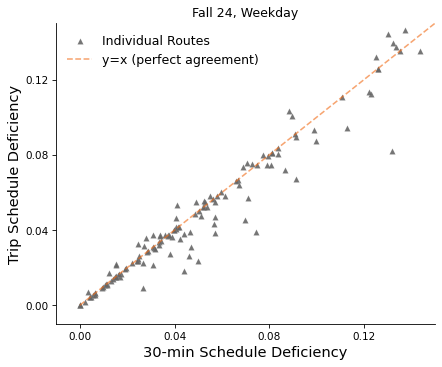

In [222]:
df = out

fig, ax = plt.subplots(figsize=(6, 5), dpi=75)
plt.scatter(df["def_hr"], df["def_rt"], s=32,color='.4',edgecolor='.8',linewidth=0.1,alpha=0.9,marker='^',label='Individual Routes')

#zone_ = AVL[(AVL['AVL']>0.05)&(AVL['APC']<0.05)]
#plt.scatter(zone_['APC'],zone_['AVL'], s=22,color='#8c2d04',edgecolor='.8',linewidth=0.1)

plt.plot([df[["def_hr","def_rt"]].min().min(), df[["def_hr","def_rt"]].max().max()],
         [df[["def_hr","def_rt"]].min().min(), df[["def_hr","def_rt"]].max().max()],
         'r--', label="y=x (perfect agreement)",color='#f16913',alpha=0.6)

ax.set_xlabel('30-min Schedule Deficiency',fontsize=14)
ax.set_ylabel('Trip Schedule Deficiency',fontsize=14)

#ax.vlines(x=0.05, ymin=0.05, ymax=0.15, color='#f16913',alpha=0.5)
#ax.hlines(y=0.05, xmin=0, xmax=0.05, color='#f16913',alpha=0.5)

plt.title('Fall 24, Weekday')

ax.legend(frameon=False, fontsize=12)
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
ax.xaxis.set_major_locator(mticker.MaxNLocator(5))
plt.xlim(-0.01,0.15)
plt.ylim(-0.01,0.15)
sns.despine()
plt.tight_layout()
plt.savefig('pm')

In [49]:
season_ranges = {
    '2023-1': (pd.Timestamp('2022-12-19'), pd.Timestamp('2023-03-10')),
    '2023-2': (pd.Timestamp('2023-03-13'), pd.Timestamp('2023-07-01')),
    '2023-3': (pd.Timestamp('2023-07-03'), pd.Timestamp('2023-08-25')),
    '2023-4': (pd.Timestamp('2023-08-28'), pd.Timestamp('2023-12-15')),
    '2024-1': (pd.Timestamp('2023-12-18'), pd.Timestamp('2024-04-05')),
    '2024-2': (pd.Timestamp('2024-04-08'), pd.Timestamp('2024-06-14')),
    '2024-3': (pd.Timestamp('2024-06-17'), pd.Timestamp('2024-08-23')),
    '2024-4': (pd.Timestamp('2024-08-25'), pd.Timestamp('2024-12-13')),
    '2025-1': (pd.Timestamp('2024-12-15'), pd.Timestamp('2025-04-05')),
    '2025-2': (pd.Timestamp('2025-04-07'), pd.Timestamp('2025-06-13')),
}

window_weeks = [2]  
results = []

for season, (start, end) in season_ranges.items():
    df_season = sd_all_mrg[
        (sd_all_mrg['service_date'] >= start) &
        (sd_all_mrg['service_date'] <= end)
    ]
    
    for w in window_weeks:
        window_start = start
        while True:
            window_end = window_start + pd.Timedelta(weeks=w) - pd.Timedelta(days=1)
            if window_end > end:
                break
            
            df_win = df_season[
                (df_season['service_date'] >= window_start) &
                (df_season['service_date'] <= window_end)
            ]
            df_win = df_win[df_win['DOW']=='Weekday']
            
            df_win = df_win[df_win['schedule_type']=='N']
            for route in list(sd_all_mrg[sd_all_mrg['DOW']=='Weekday'].route_id.unique()):
                df_win2 = df_win[df_win['route_id'] == route]
                if not df_win2.empty and (window_end- window_start).days >=5 and len(df_win2)>50:

                    avg_run       = df_win2['actual_run'].mean()
                    lens = len(df_win2)
    
                    agg = df_win2.groupby('time_dir').agg(
                        actual_run_q90=('actual_run', lambda x: x.quantile(0.90)),
                        schdL     =('schdLO',    'mean'),
                        mean_lo     =('Act_Layover',    'mean')).reset_index()
                    
                    df_out = df_win2.merge(agg[['time_dir','actual_run_q90','schdL']],on='time_dir',how='left')
                
                    df_out = df_out.drop_duplicates('time_dir')[['actual_run_q90','schdL','time_dir','season','holiday','direction_id','schedule_type','hour_Startpoint',
                                                                 'scheduledhm_Startpoint','DOW']]

                    defs = df_out[df_out['actual_run_q90']>df_out['schdL']]
                    defic = np.sum(defs['actual_run_q90'] - defs['schdL'])/np.sum(df_out['schdL'])
                    
                    surp = df_out[df_out['actual_run_q90']<df_out['schdL']]
                    surps = np.sum(surp['schdL'] - surp['actual_run_q90'])/np.sum(df_out['schdL'])
                                    
                    results.append({
                        'season': season,
                        'route': route,
                        'window_weeks': w,
                        'window_start': window_start.date(),
                        'window_end': window_end.date(),
                        'pct_deficient': defic,
                        'pct_surp': surps,
                        'avg_actual_run': avg_run,
                        'lens':lens
                     })
                
            window_start += pd.Timedelta(weeks=w)

results_df = pd.DataFrame(results)



In [50]:
hds = ['01', '07', '09', '101', '109', '11',
       '111', '116', '117', '15', '16', '21', '216', '22', '23', '28',
       '31', '32', '34', '36', '37', '39', '57', '65', '66', '71', '73',
       '743', '77', '86', '104', '17', '44', '504', '69', '70',
       '89', '225', '42', '47', '442', '110', '45', '83', '64',
       '240', '78', '88', '501', '411', '108', '134', '30', '24', '35',
       '38', '426', '93', '455', '19', '120', '95', '429', '10', '210',
       '51', '87', '230', '430', '137', '220', '211', '94', '08', '712',
       '713', '04', '215', '92']

hds = list(map(int, hds))  

In [51]:
results_df = pd.DataFrame(results)

print(len(results_df.route.unique()))
#results_df = results_df[results_df['route'].isin(hds)]
len(results_df.route.unique())

140


140

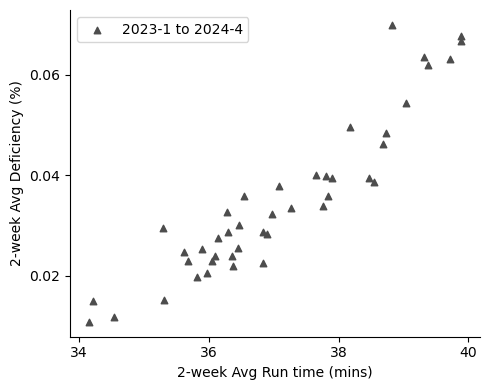

In [63]:
plt1 = results_df[(results_df['route'] == 23)&(~results_df['season'].isin(['2025-1','2025-2']))].copy()

fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

plt.scatter(plt1['avg_actual_run'],plt1['pct_deficient'],color='.3',s=22,marker='^',label='2023-1 to 2024-4')
#plt.scatter(plt1['avg_actual_run'],plt1['pct_surp'],color=colors[k],s=12)

plt1 = results_df[(results_df['route'] == 23)&(results_df['season'].isin(['2025-1','2025-2']))].copy()


#plt.scatter(plt1['avg_actual_run'],plt1['pct_deficient'],color='#d94801',s=22,marker='^',label='2025-1 to 2025-2')
plt.legend()
plt.xlabel('2-week Avg Run time (mins)')
plt.ylabel('2-week Avg Deficiency (%)')
sns.despine()
plt.tight_layout()

ax.xaxis.set_major_locator(mticker.MaxNLocator(4))
ax.yaxis.set_major_locator(mticker.MaxNLocator(4))
plt.savefig('pm')

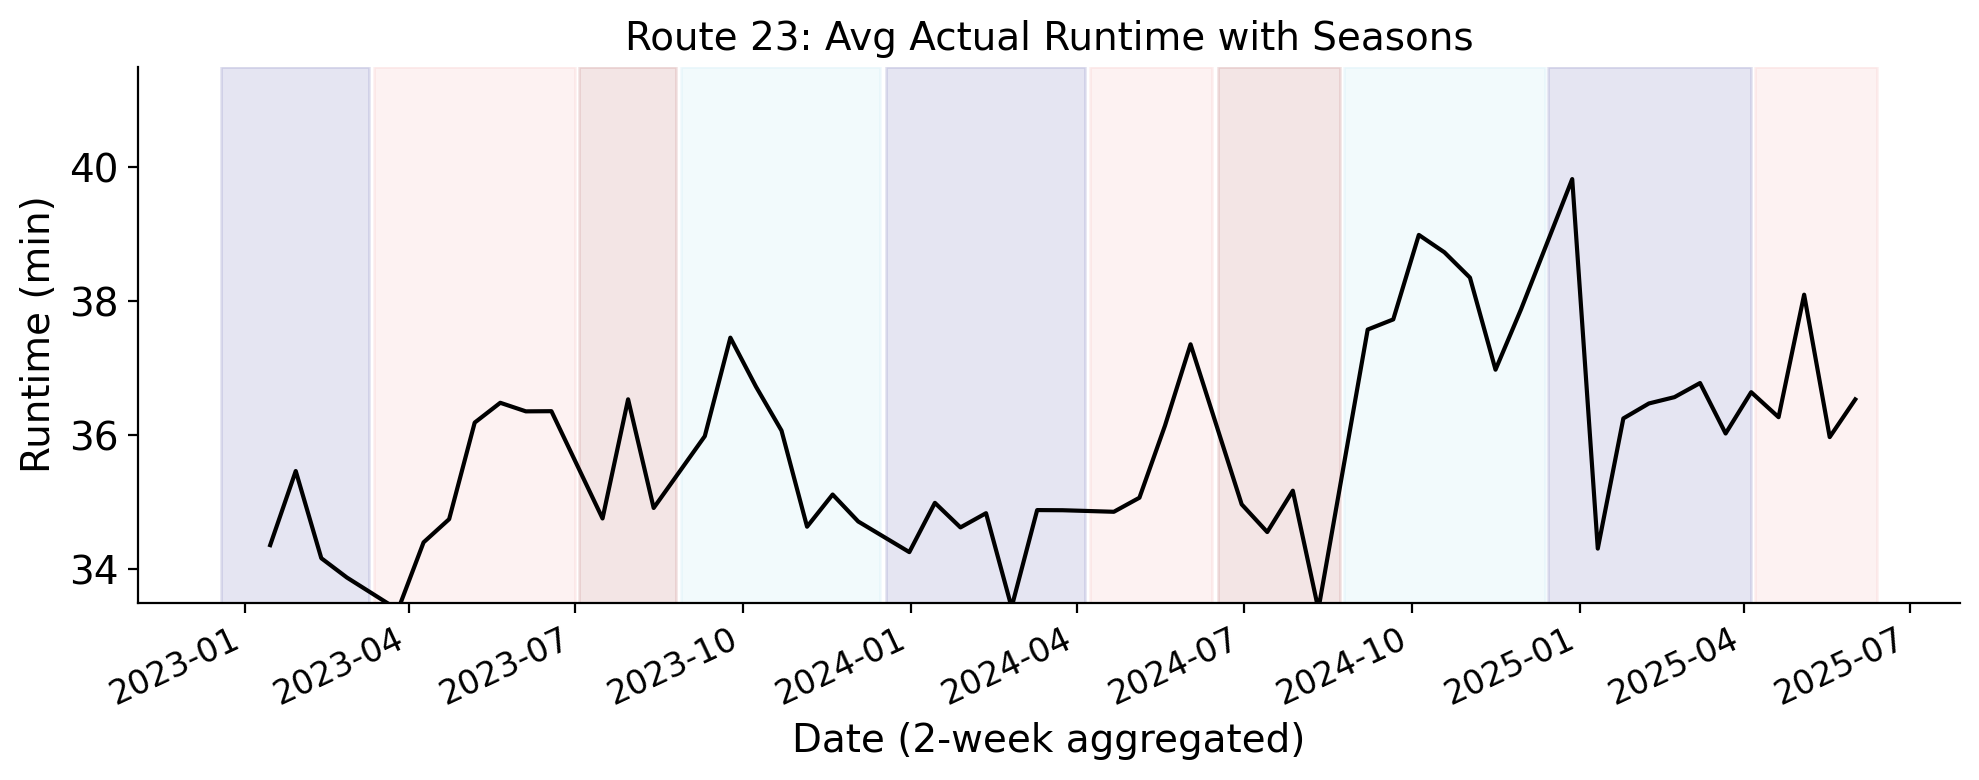

In [507]:
quarter_colors = {
    1: 'navy',       # winter
    2: 'lightcoral', # spring
    3: 'darkred',    # summer
    4: 'skyblue',    # fall
}
results_df["window_start"] = pd.to_datetime(results_df["window_start"])
results_df["window_end"] = pd.to_datetime(results_df["window_end"])

cutoff = pd.Timestamp("2024-12-15")     

plt1 = results_df[(results_df['route'] == 411)].copy()
#plt1 = results_df[(results_df['route'] == 23)&(results_df['window_start']<cutoff)].copy()

fig, ax = plt.subplots(figsize=(10, 4), dpi=200)

ax.plot(plt1['window_end'], plt1['avg_actual_run'], label='Surplus %', color='black')

for season, (start, end) in season_ranges.items():
    q = int(season.split('-')[1])
    ax.axvspan(start, end, color=quarter_colors[q], alpha=0.1)

# Add seasonal background spans
for season, (start, end) in season_ranges.items():
    q = int(season.split('-')[1])

#vline_date = pd.to_datetime('2024-12-14')
#ax.axvline(x=vline_date, color='red', linestyle='--', label='Schedule change')

ax.set_xlabel('Date (2-week aggregated)',fontsize=14)
plt.ylim(33.5,41.5) # for 23
plt.ylim(33.5,41.5) # for 23
ax.set_ylabel('Runtime (min)',fontsize=14)
ax.set_title('Route 23: Avg Actual Runtime with Seasons',fontsize=14)
ax.yaxis.set_major_locator(mticker.MaxNLocator(4))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xticks(rotation=25, ha='right') 
#ax.legend(loc='upper left')
sns.despine()
plt.tight_layout()
plt.savefig('pm')

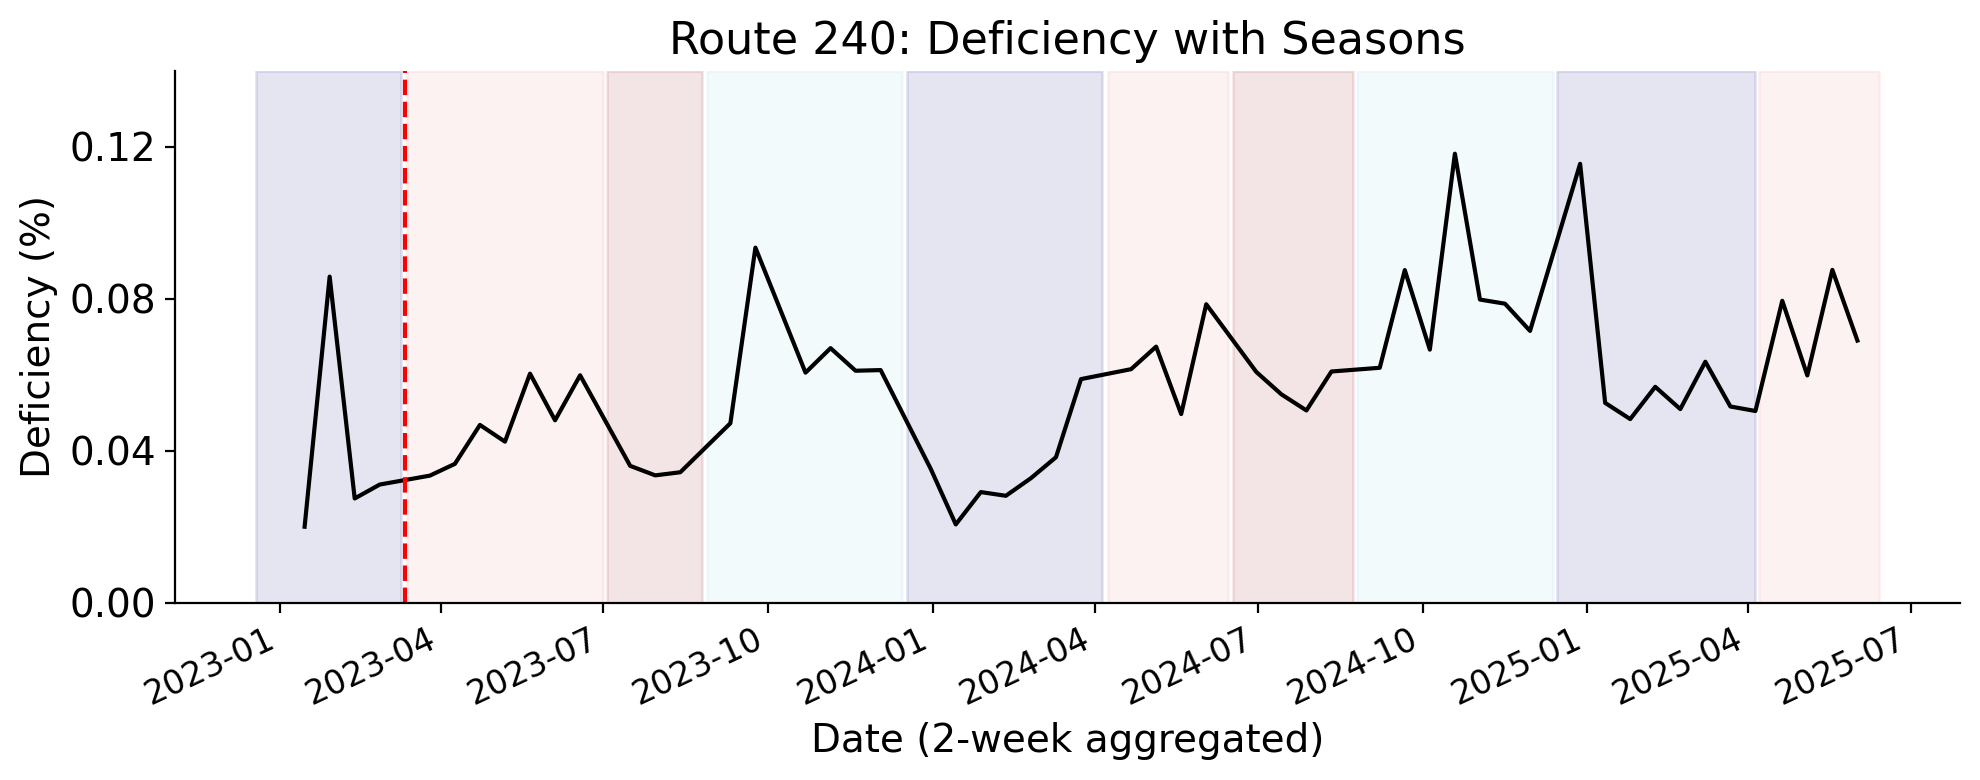

In [509]:
quarter_colors = {
    1: 'navy',       # winter
    2: 'lightcoral', # spring
    3: 'darkred',    # summer
    4: 'skyblue',    # fall
}
results_df["window_start"] = pd.to_datetime(results_df["window_start"])
results_df["window_end"] = pd.to_datetime(results_df["window_end"])

cutoff = pd.Timestamp("2024-12-15")    

plt1 = results_df[(results_df['route'] == 41)].copy()
#plt1 = results_df[(results_df['route'] == 23)&(results_df['window_start']<cutoff)].copy()

fig, ax = plt.subplots(figsize=(10, 4), dpi=200)

ax.plot(plt1['window_end'], plt1['pct_deficient'], label='Surplus %', color='black')

for season, (start, end) in season_ranges.items():
    q = int(season.split('-')[1])
    ax.axvspan(start, end, color=quarter_colors[q], alpha=0.1)

# Add seasonal background spans
for season, (start, end) in season_ranges.items():
    q = int(season.split('-')[1])

vline_date = pd.to_datetime('2024-12-14')
vline_date = pd.to_datetime('2023-03-12')

ax.axvline(x=vline_date, color='red', linestyle='--', label='Schedule change')

ax.set_xlabel('Date (2-week aggregated)',fontsize=14)
#plt.ylim(0,0.075) #for 23
#plt.ylim(0,0.1) # for 411
plt.ylim(0,0.14) # for 240
ax.set_ylabel('Deficiency (%)',fontsize=14)
ax.set_title('Route 240: Deficiency with Seasons',fontsize=16)
ax.yaxis.set_major_locator(mticker.MaxNLocator(4))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xticks(rotation=25, ha='right') 
#ax.legend(loc='upper left')
sns.despine()
plt.tight_layout()
plt.savefig('pm')

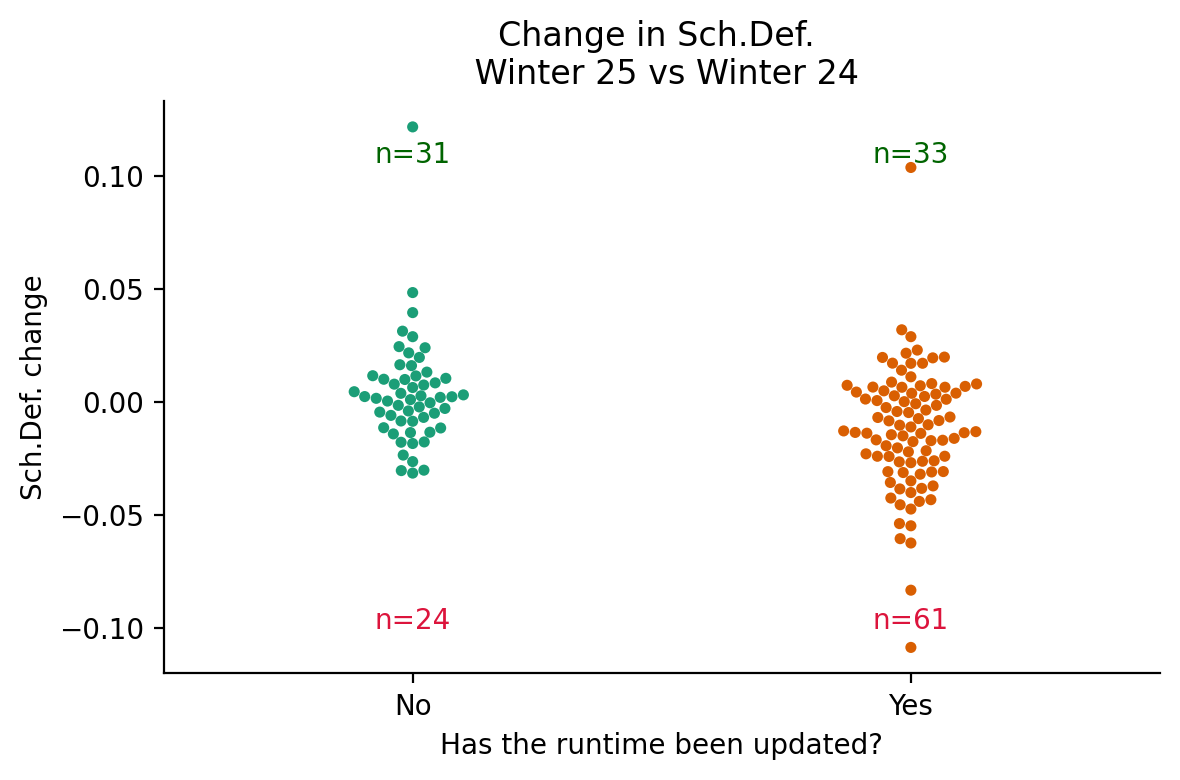

In [274]:
wi24 = pd.read_excel('winter_2024.xlsx')
wi25 = pd.read_excel('winter_2025.xlsx')

wi24 = wi24[['Route','Measure Values']]
wi24 = wi24.rename(columns={'Measure Values':'wi24'})

wi25 = wi25[['Route','Measure Values']]
wi25 = wi25.rename(columns={'Measure Values':'wi25'})

wis = wi24.merge(wi25).dropna()
wis['diff'] = wis['wi25']-wis['wi24']


changes = pd.read_excel('Most Recent Changes.xlsx')
changes = changes[changes['Change Type'].isin(['Runtime','Runtime and Headway','Routing & Runtime'])]

changes_= changes[changes['Rating_CL'].isin(['Winter 2025','Winter 2024','Spring 2024','Summer 2024','Fall 2024'])]
changes_ = changes_.drop_duplicates('Route1')
changed= list(changes_.Route1)

wis["changed"] = wis["Route"].isin(changed)
wis["changed"] = np.where(wis["Route"].isin(changed), "Yes", "No")


fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
sns.swarmplot(data=wis, x="changed", y="diff", size=4,
              palette="Dark2", ax=ax)

tbl = (wis
       .assign(sign=np.where(wis["diff"] >= 0, ">0", "<0"))
       .groupby(["changed", "sign"])
       .size()
       .unstack(fill_value=0))          

ymax, ymin = wis["diff"].max(), wis["diff"].min()
for xpos, label in enumerate(ax.get_xticklabels()):
    grp = label.get_text()              # "yes" or "no"
    up  = int(tbl.loc[grp, ">0"]) if ">0" in tbl.columns else 0
    dn  = int(tbl.loc[grp, "<0"]) if "<0" in tbl.columns else 0

    ax.text(xpos, ymax*0.95, f"n={up}",  ha="center", va="top",
            fontsize=10, color="darkgreen")
    ax.text(xpos, ymin*0.95, f"n={dn}", ha="center", va="bottom",
            fontsize=10, color="crimson")


highlight = wis[(wis["changed"] == "Yes") & (wis["diff"] >= 0)]

#sns.swarmplot(data=highlight,x="changed",y="diff",size=4,color="#D95F02FF",      # ← one fixed colourax=ax,edgecolor="black",linewidth=0.3)

sns.despine()

ax.set_ylabel("Sch.Def. change")
ax.set_xlabel("Has the runtime been updated?")
ax.set_title("Change in Sch.Def. \n Winter 25 vs Winter 24")
plt.tight_layout()
plt.savefig('pm')

In [272]:

southhampton = ['16', '28', '39', '741', '742', '743', '746', '749', '751']
somerville   = ['61', '62', '64', '67', '68', '69', '70', '71', '73', '74', '75', '76', '77', '78', '80', '83', '85', '86', '87', '88', '350', '351']
quincy       = ['201', '202', '210', '211', '215', '216', '217', '220', '222', '225', '226', '230', '236', '238', '240', '245']
lynn         = ['114', '116', '119', '120', '121', '424', '426', '428', '429', '435', '436', '439', '441', '442', '450', '451', '455', '456']
charlestown  = ['89', '90', '91', '92', '93', '94', '95', '96', '97', '99', '100', '101', '104', '105', '106', '108', '109', '110', '111', '112', '131', '132', '134', '137', '194', '354', '411', '430']
cabot        = ['1', '4', '7', '8', '9', '10', '11', '15', '16', '17', '18', '19', '22', '23', '28', '43', '44', '45', '47', '55', '57', '59', '60', '65', '66', '171', '191', '193', '501', '504', '505', '553', '554', '556', '558', '708', '747']
arborway     = ['14', '21', '24', '26', '28', '29', '30', '31', '32', '33', '34', '34E', '35', '36', '37', '38', '40', '41', '42', '50', '51', '52', '192']

term_to_quarter = {'Winter':1, 'Spring':2, 'Summer':3, 'Fall':4, 'Autumn':4}

def rating_to_season_code(rating: str) -> str:
    term, year = rating.split()
    return f"{year}-{term_to_quarter[term]}"

In [275]:
season_ranges = {
    '2023-1': (pd.Timestamp('2022-12-19'), pd.Timestamp('2023-03-10')),
    '2023-2': (pd.Timestamp('2023-03-13'), pd.Timestamp('2023-07-01')),
    '2023-3': (pd.Timestamp('2023-07-03'), pd.Timestamp('2023-08-25')),
    '2023-4': (pd.Timestamp('2023-08-28'), pd.Timestamp('2023-12-15')),
    '2024-1': (pd.Timestamp('2023-12-18'), pd.Timestamp('2024-04-05')),
    '2024-2': (pd.Timestamp('2024-04-08'), pd.Timestamp('2024-06-14')),
    '2024-3': (pd.Timestamp('2024-06-17'), pd.Timestamp('2024-08-23')),
    '2024-4': (pd.Timestamp('2024-08-25'), pd.Timestamp('2024-12-13')),
    '2025-1': (pd.Timestamp('2024-12-15'), pd.Timestamp('2025-04-05')),
    '2025-2': (pd.Timestamp('2025-04-07'), pd.Timestamp('2025-06-13')),
}

results2 = []

for season, (start, end) in season_ranges.items():
    df_season = sd_all_mrg[
        (sd_all_mrg['service_date'] >= start) &
        (sd_all_mrg['service_date'] <= end)
    ]
    

    df_win = df_season
    df_win = df_win[df_win['DOW']=='Weekday']
    
    df_win = df_win[df_win['schedule_type']=='N']
    for route in list(sd_all_mrg[sd_all_mrg['DOW']=='Weekday'].route_id.unique()):
        df_win2 = df_win[df_win['route_id'] == route]
        if not df_win2.empty and (window_end- window_start).days >=5 and len(df_win2)>50:

            avg_run       = df_win2['actual_run'].mean()
            lens = len(df_win2)

            agg = df_win2.groupby('time_dir').agg(
                actual_run_q90=('actual_run', lambda x: x.quantile(0.90)),
                schdL     =('schdLO',    'mean'),
                mean_lo     =('Act_Layover',    'mean')).reset_index()
            
            df_out = df_win2.merge(agg[['time_dir','actual_run_q90','schdL']],on='time_dir',how='left')
        
            df_out = df_out.drop_duplicates('time_dir')[['actual_run_q90','schdL','time_dir','season','holiday','direction_id','schedule_type','hour_Startpoint',
                                                         'scheduledhm_Startpoint','DOW']]

            defs = df_out[df_out['actual_run_q90']>df_out['schdL']]
            defic = np.sum(defs['actual_run_q90'] - defs['schdL'])/np.sum(df_out['schdL'])
            
            surp = df_out[df_out['actual_run_q90']<df_out['schdL']]
            surps = np.sum(surp['schdL'] - surp['actual_run_q90'])/np.sum(df_out['schdL'])
                            
            results2.append({
                'season': season,
                'route': route,
                'window_weeks': w,
                'window_start': start.date(),
                'window_end': end.date(),
                'pct_deficient': defic,
                'pct_surp': surps,
                'avg_actual_run': avg_run,
                'lens':lens
             })
        
results_df2 = pd.DataFrame(results2)



In [ ]:
results_df2 = pd.DataFrame(results2)
seasons_to_show = ['2024-3','2024-4',
                   '2025-1','2025-2']
results_df2 = results_df2[results_df2['season'].isin(seasons_to_show)]

#quincy, lynn,charlestown,arborway,cabot
highlight_routes = cabot
day_type_filter = 'Weekday'      

def season_to_ord(season_code: str) -> int:
    y, q = season_code.split('-')
    return int(y) * 10 + int(q)

fig, ax = plt.subplots(figsize=(5, 4), dpi=50)
ax.scatter(results_df2['pct_deficient'], results_df2['pct_surp'],
           color='.3', s=1, alpha=0.1, label='All routes')

#alette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
palette = ['.4', '.4','.4','.4','.4','.4','.4']

all_fcs = pd.DataFrame()
for route in highlight_routes:
    focus = results_df2[results_df2['route'].astype(str) == str(route)].copy()
    if focus.empty:
        continue

    chg = changes[changes['Route1'].astype(str) == str(route)]
    if 'Day Type' in changes.columns:
        chg = chg[chg['Day Type'] == day_type_filter]

    chg_seasons = []
    if 'Rating_CL' in chg.columns:
        chg_seasons = [rating_to_season_code(x) for x in chg['Rating_CL']]
    chg_ord = np.array(sorted(season_to_ord(s) for s in chg_seasons), dtype=int)

    focus['season_ord'] = focus['season'].map(season_to_ord)
    focus['seg'] = np.searchsorted(chg_ord, focus['season_ord'], side='right')
    all_fcs = pd.concat([all_fcs,focus])
    if len(chg_seasons) == 0:
        seg_labels = ['no rating change']
    else:
        seg_labels = ['Before ' + chg_seasons[0]]
        for i in range(1, len(chg_seasons)):
            seg_labels.append(f"Between {chg_seasons[i-1]} - {chg_seasons[i]}")
        seg_labels.append('After ' + chg_seasons[-1])
    for seg_idx, g in focus.groupby('seg'):
        color = palette[seg_idx % len(palette)]
        label = f"Route {route} — {seg_labels[seg_idx] if seg_idx < len(seg_labels) else f'segment {seg_idx}'}"
        ax.scatter(g['pct_deficient'], g['pct_surp'], s=22, color=color, alpha=0.95,label='Garage Routes')

ax.set_xlim(-0.01, 0.20)
ax.set_xlabel('Deficiency %',fontsize=14)
ax.set_ylabel('Surplus %',fontsize=14)
plt.title('Cabot',fontsize=14)
#ax.legend(frameon=False, fontsize=8, loc='best')

ax.xaxis.set_major_locator(mticker.MaxNLocator(4))
ax.yaxis.set_major_locator(mticker.MaxNLocator(4))

plt.tight_layout()
sns.despine()
plt.savefig('ap1')


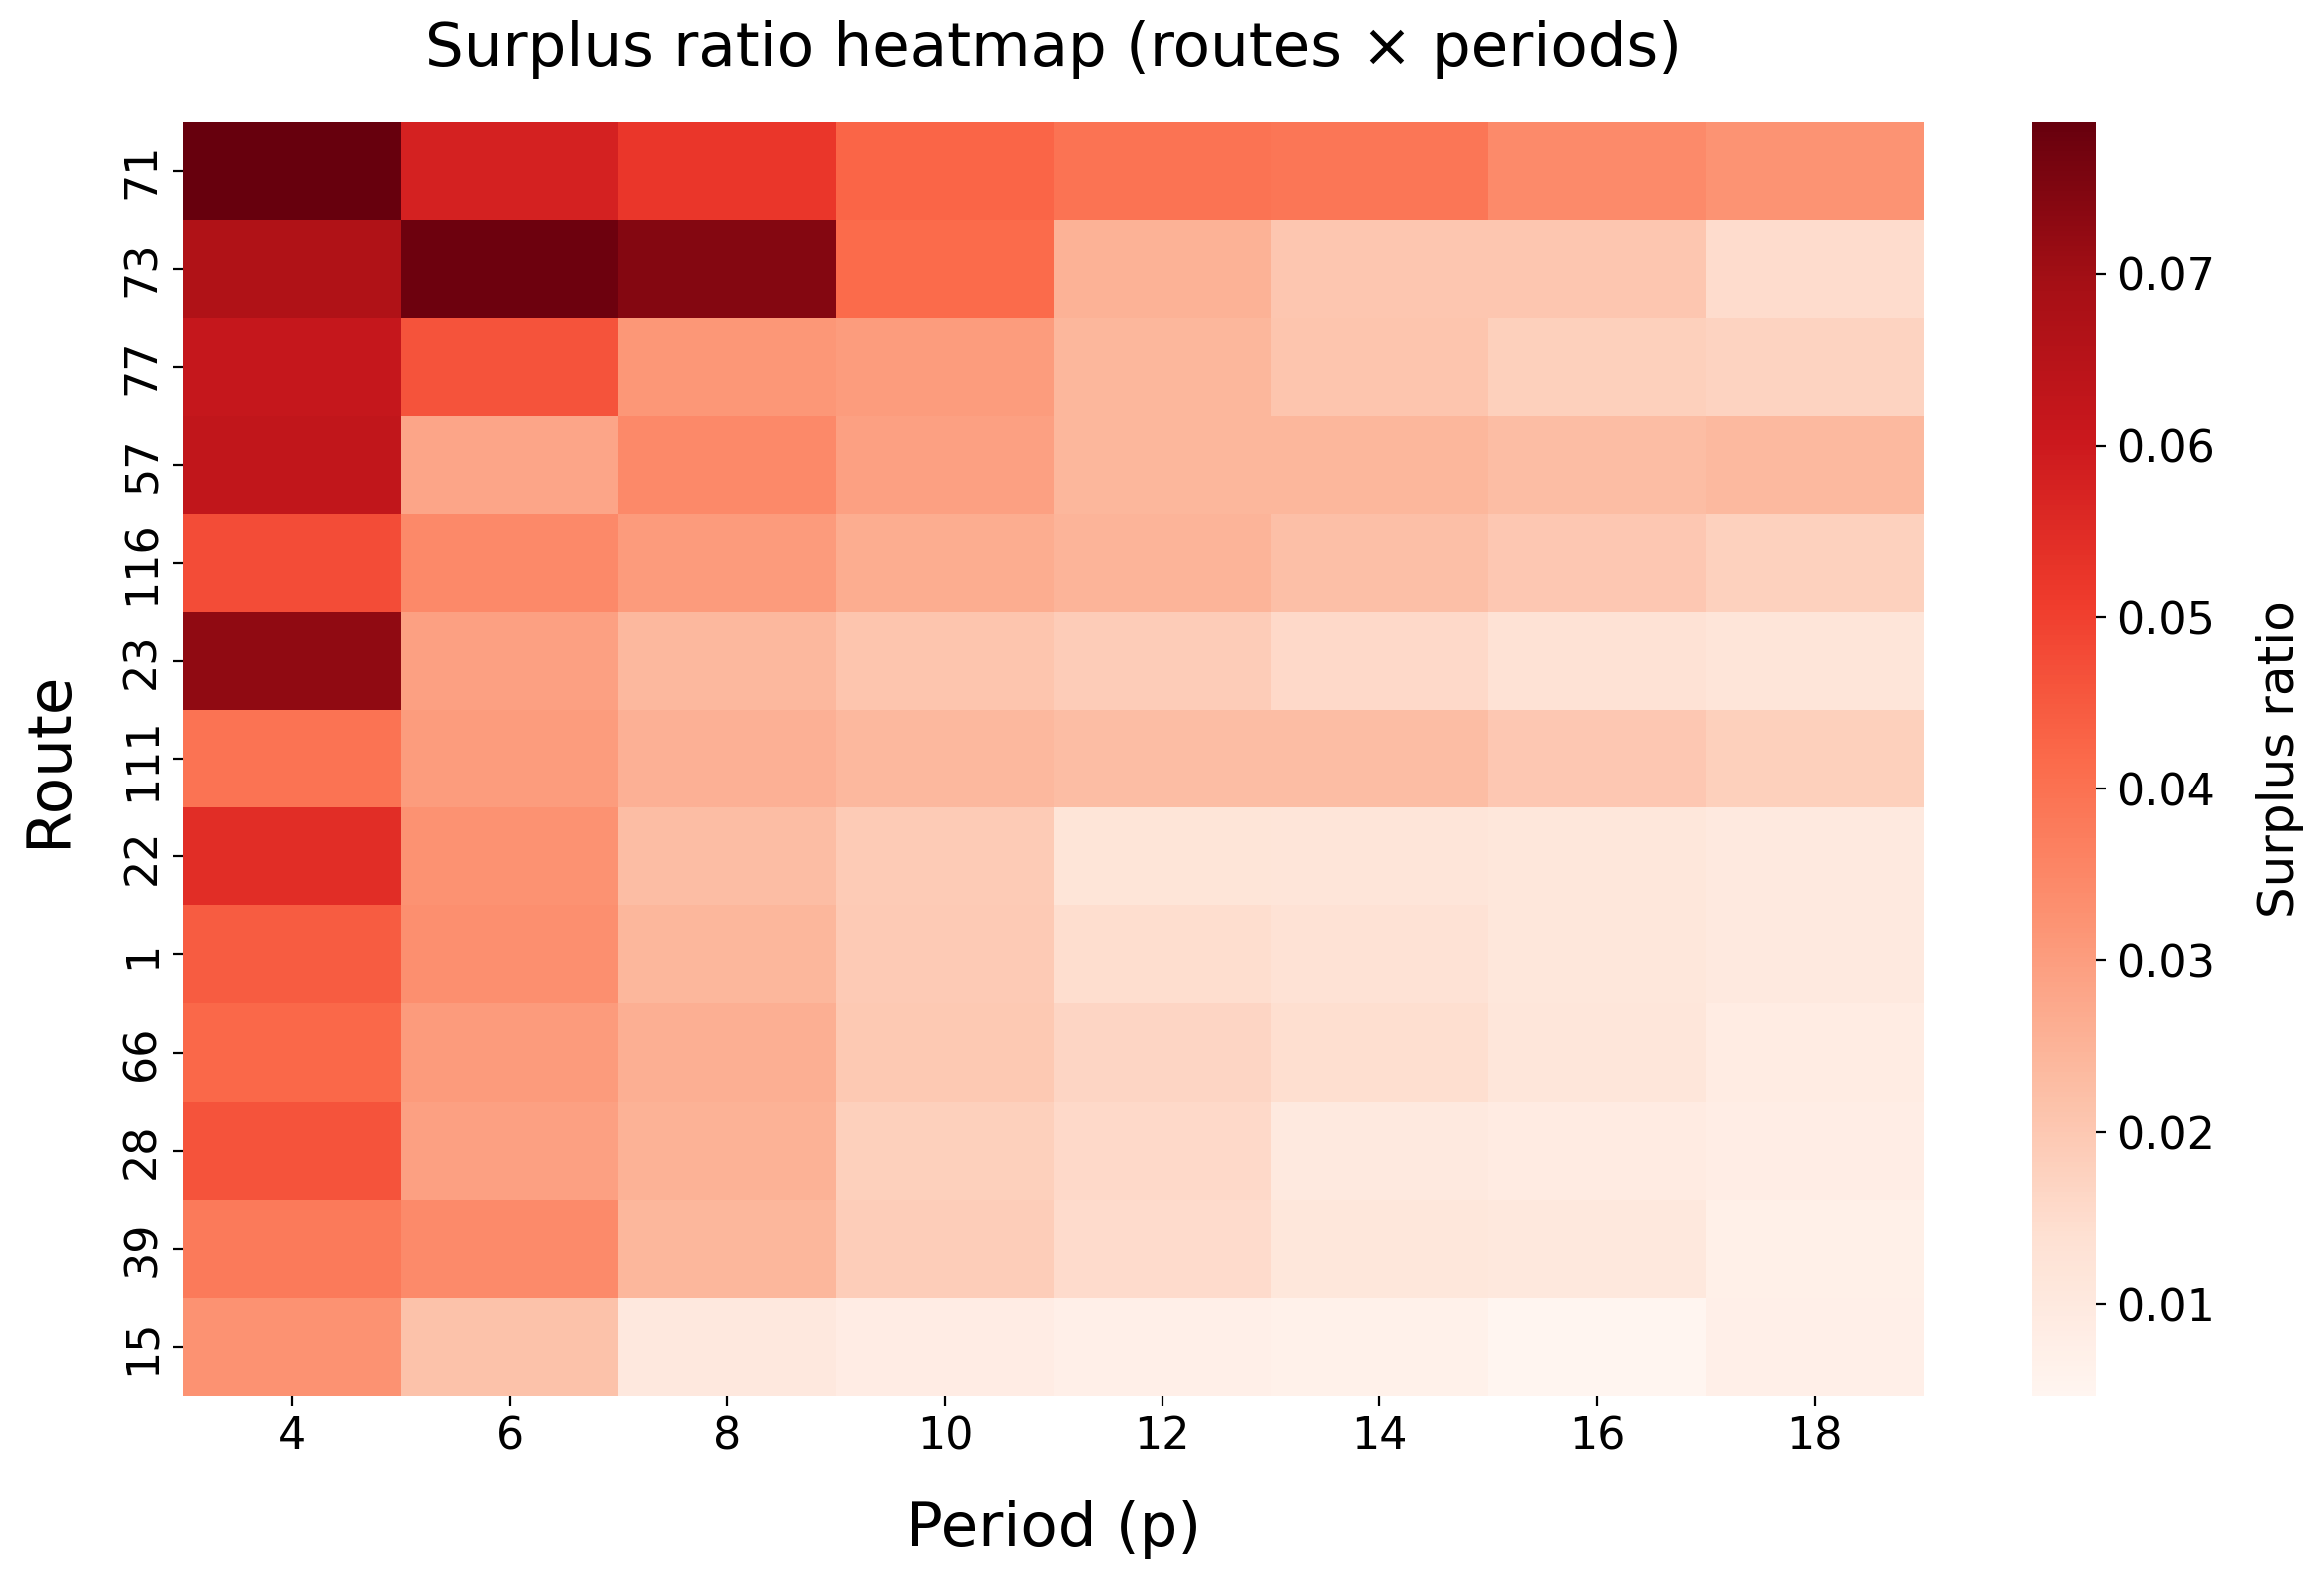

In [210]:
routes = [1,15,22,23,28,39,57,66,71,73,77,111,116,117,741,742,743,751,749] 

period_tables = pd.read_csv('tables.csv') 
period_tables['surplus_ratio'] = period_tables['surplus_ratio']*-1 
period_tables = period_tables[period_tables['route'].isin(routes)] 

df2 = period_tables[period_tables['runtime_label']=='2025-1'] 
df2 = df2[df2['p'] < 19] 

pv = pd.pivot_table( df2, index='route', columns='p', values='surplus_ratio', aggfunc='mean' ) 

pv = pv.dropna() 
route_order = pv.mean(axis=1).sort_values(ascending=False).index 
pv = pv.loc[route_order] 
pv = pv.reindex(sorted(pv.columns), axis=1)

fig, ax = plt.subplots(figsize=(12, 8), dpi=200)
hm = sns.heatmap(
    pv,
    cmap='Reds',
    cbar_kws={'label': 'Surplus ratio'},
    square=False
)

plt.title('Surplus ratio heatmap (routes × periods)', fontsize=22, pad=20)
ax.set_ylabel('Route', fontsize=22, labelpad=15)   
ax.set_xlabel('Period (p)', fontsize=22, labelpad=15)  
plt.xticks(fontsize=16, rotation=0, ha="center")
plt.yticks(fontsize=16)

cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Surplus ratio', fontsize=18, labelpad=15)

plt.tight_layout()
plt.savefig('pm')